In [1]:
!date

Thu Nov 19 15:01:42 PST 2020


# Sex isoform subclass DE 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os
import anndata

def nd(arr):
    return np.asarray(arr).reshape(-1)

import sys
sys.path.append('/home/sina/projects/mop/BYVSTZP_2020/dexpress')
from dexpress import dexpress, utils, plot

sys.path.append('/home/sina/projects/mop/BYVSTZP_2020/trackfig')
from trackfig.utils import get_notebook_name
from trackfig.trackfig import trackfig 

TRACKFIG = "/home/sina/projects/mop/BYVSTZP_2020/trackfig.txt"
NB = get_notebook_name()

fsize=15

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [2]:
isoform = anndata.read_h5ad("../../data/notebook/revision/sex_isoform.h5ad")

In [3]:
cols = ["transcript_id", "gene_id", "gene_name", "transcript_name", "chromosome", "start", "stop", "strand"]
t2g = pd.read_csv("../../reference/t2g.txt", sep="\t", header=None, names=cols)
t2g.index = t2g.transcript_id.apply(lambda x: x.split(".")[0]).values

In [4]:
isoform.var["chromosome"] = isoform.var.transcript_id.map(t2g["chromosome"]).values

In [5]:
isoform.obs.head()

,cluster_id,cluster_label,subclass_label,class_label,cluster_color,size,cell_id,subclass_id,class_id,cell_counts,leiden,louvain,sex
0,10,Vip Chat_1,Vip,GABAergic,#FF00FF,33,LS-15395_S47_E1-50,17,0,998372.1875,5,6,F
1,38,L5 IT S100b_2,L5 IT,Glutamatergic,#2F8C4D,83,LS-15395_S48_E1-50,3,1,998955.6875,10,10,F
2,4,Lamp5 Slc35d3,Lamp5,GABAergic,#FFA388,194,LS-15395_S49_E1-50,10,0,998189.4375,9,9,F
3,38,L5 IT S100b_2,L5 IT,Glutamatergic,#2F8C4D,83,LS-15395_S50_E1-50,3,1,999028.6250,10,10,F
4,20,Sst Myh8_2,Sst,GABAergic,#D27A2A,55,LS-15395_S51_E1-50,15,0,998751.8750,7,7,F


In [6]:
isoform = isoform[~isoform.obs.eval("subclass_label == 'Low Quality'").values]

08-Dec-20 00:09:19 - Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
08-Dec-20 00:09:19 - NumExpr defaulting to 8 threads.


In [7]:
clusters = np.unique(isoform.obs.subclass_label.values)

In [8]:
clusters

array(['Astro', 'Endo', 'L2/3 IT', 'L5 IT', 'L5 PT', 'L5/6 NP', 'L6 CT',
       'L6 IT', 'L6 IT Car3', 'L6b', 'Lamp5', 'Pvalb', 'SMC', 'Sncg',
       'Sst', 'VLMC', 'Vip'], dtype=object)

In [9]:
isoform.obs.sex.value_counts()

M    4199
F    1949
Name: sex, dtype: int64

In [10]:
%%time
de_clusters = []
de_isoforms = []
for cidx, c in enumerate(clusters):
    print(f"{cidx+1} of {len(clusters)}: {c}")
    tmp_isoform = isoform[isoform.obs.eval(f"subclass_label == '{c}'")].copy()
    if tmp_isoform.obs.sex.nunique() > 1:

        ######### Isoforms
        mat           = tmp_isoform.layers["log1p"].todense()
        components    = tmp_isoform.obs.cell_id.values
        features      = tmp_isoform.var.transcript_name.values
        assignments   = tmp_isoform.obs.sex.values

        # parameters
        unique        = np.unique(assignments)
        nan_cutoff    = 0.9 # of elements in cluster
        corr_method   = "bonferroni"


        p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
        p_raw = p_raw/2
        p_corr = utils.correct_pvals(p_raw)#, nfeat, corr_method)

        s = stat

        markers_isoform = dexpress.make_table(assignments, features, p_raw, p_corr, es)

        # convert the 0 pvalues to the smallest possible float
        markers_isoform["p_corr"][markers_isoform.eval("p_corr == 0").values] = sys.float_info.min
        markers_isoform = markers_isoform.query("es>0")
        markers_isoform["cluster"] = c
        de_isoforms.append(markers_isoform)

08-Dec-20 00:09:20 - 1 of 2 assignments: F
08-Dec-20 00:09:20 - 2 of 2 assignments: M


1 of 17: Astro


08-Dec-20 00:09:20 - 1 of 2 assignments: F
08-Dec-20 00:09:20 - 2 of 2 assignments: M


2 of 17: Endo
3 of 17: L2/3 IT


08-Dec-20 00:09:21 - 1 of 2 assignments: F
08-Dec-20 00:09:21 - 2 of 2 assignments: M


4 of 17: L5 IT


08-Dec-20 00:09:23 - 1 of 2 assignments: F
08-Dec-20 00:09:24 - 2 of 2 assignments: M
08-Dec-20 00:09:25 - 1 of 2 assignments: F
08-Dec-20 00:09:25 - 2 of 2 assignments: M


5 of 17: L5 PT
6 of 17: L5/6 NP


08-Dec-20 00:09:25 - 1 of 2 assignments: F
08-Dec-20 00:09:25 - 2 of 2 assignments: M


7 of 17: L6 CT


08-Dec-20 00:09:27 - 1 of 2 assignments: F
08-Dec-20 00:09:27 - 2 of 2 assignments: M


8 of 17: L6 IT


08-Dec-20 00:09:28 - 1 of 2 assignments: F
08-Dec-20 00:09:28 - 2 of 2 assignments: M
08-Dec-20 00:09:28 - 1 of 2 assignments: F
08-Dec-20 00:09:29 - 2 of 2 assignments: M


9 of 17: L6 IT Car3
10 of 17: L6b


08-Dec-20 00:09:30 - 1 of 2 assignments: F
08-Dec-20 00:09:30 - 2 of 2 assignments: M


11 of 17: Lamp5


08-Dec-20 00:09:31 - 1 of 2 assignments: F
08-Dec-20 00:09:31 - 2 of 2 assignments: M


12 of 17: Pvalb


08-Dec-20 00:09:32 - 1 of 2 assignments: F
08-Dec-20 00:09:32 - 2 of 2 assignments: M
08-Dec-20 00:09:32 - 1 of 2 assignments: F
08-Dec-20 00:09:32 - 2 of 2 assignments: M


13 of 17: SMC


08-Dec-20 00:09:32 - 1 of 2 assignments: F
08-Dec-20 00:09:33 - 2 of 2 assignments: M


14 of 17: Sncg
15 of 17: Sst


08-Dec-20 00:09:33 - 1 of 2 assignments: F
08-Dec-20 00:09:33 - 2 of 2 assignments: M
08-Dec-20 00:09:34 - 1 of 2 assignments: F
08-Dec-20 00:09:34 - 2 of 2 assignments: M


16 of 17: VLMC
17 of 17: Vip


08-Dec-20 00:09:35 - 1 of 2 assignments: F
08-Dec-20 00:09:35 - 2 of 2 assignments: M


CPU times: user 9.58 s, sys: 6.12 s, total: 15.7 s
Wall time: 15.7 s


In [11]:
markers_isoform = pd.concat(de_isoforms)

In [12]:
alpha = 0.01
markers_isoform = markers_isoform.query(f"p_corr < {alpha}")

In [13]:
markers_isoform["chromosome"] = markers_isoform.name.apply(lambda x: x.split("_")[-1]).map(t2g["chromosome"])

In [71]:
markers_isoform.sort_values(["es"]).query("chromosome != 'X' & chromosome != 'Y' & cluster != 'L5 IT'").name.nunique()

418

In [15]:
i = "Lamp5-201_ENSMUST00000057503"
s = "L5 IT"
data = []
data.append(nd(isoform[isoform.obs.query(f"sex=='M' & subclass_label == '{s}'").index].layers["log1p"][:, (isoform.var.transcript_name == i).values].todense()))
data.append(nd(isoform[isoform.obs.query(f"sex=='F' & subclass_label == '{s}'").index].layers["log1p"][:, (isoform.var.transcript_name == i).values].todense()))

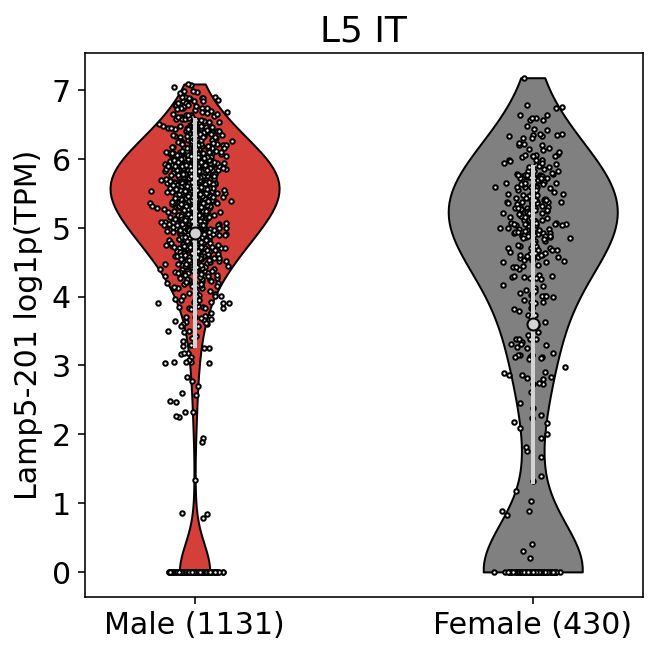

In [16]:
fig, ax = plt.subplots(figsize=(5,5))
nm = data[0].shape[0]
nf = data[1].shape[0]
plot.violinplot(data, ax, selected = 0)

ax.set(**{
    "xticks": [1,2], 
    "xticklabels": [f"Male ({nm})", f"Female ({nf})"],
    "title": f"{s}",
    "ylabel": f"{''.join(i.split('_')[:-1])} log1p(TPM)"
})

#plt.savefig(trackfig("../../figures/subclass_sex_violin_{}.png".format("-".join(s.split(" "))), TRACKFIG, NB), bbox_inches='tight',dpi=300)

fig.show()

In [17]:
stats.ttest_ind(*data)

Ttest_indResult(statistic=12.47051471425865, pvalue=4.310712696309468e-34)

#### Male and female across all cells

In [18]:
# i = "Mrpl48-203_ENSMUST00000127253"
# s = "L5 PT"
data = []
data.append(nd(isoform[isoform.obs.query(f"sex=='M' & subclass_label != '{s}'").index].layers["log1p"][:, (isoform.var.transcript_name == i).values].todense()))
data.append(nd(isoform[isoform.obs.query(f"sex=='F' & subclass_label != '{s}'").index].layers["log1p"][:, (isoform.var.transcript_name == i).values].todense()))

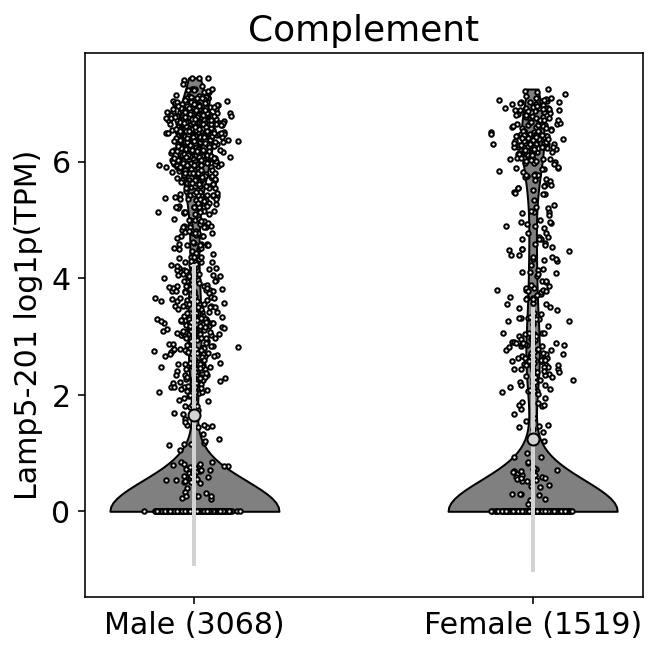

In [19]:
fig, ax = plt.subplots(figsize=(5,5))
nm = data[0].shape[0]
nf = data[1].shape[0]
plot.violinplot(data, ax)

ax.set(**{
    "xticks": [1,2], 
    "xticklabels": [f"Male ({nm})", f"Female ({nf})"],
    "title": "Complement",
    "ylabel": f"{''.join(i.split('_')[:-1])} log1p(TPM)"
})

#plt.savefig(trackfig("../../figures/subclass_sex_violin_all_cells.png", TRACKFIG, NB), bbox_inches='tight',dpi=300)

fig.show()

In [20]:
stats.ttest_ind(*data)

Ttest_indResult(statistic=5.359057839818849, pvalue=8.775877908165312e-08)

In [21]:
markers_isoform.groupby("cluster")["name"].nunique()/markers_isoform.groupby("cluster")["name"].nunique().sum()

cluster
Astro      0.001407
Endo       0.019704
L2/3 IT    0.016186
L5 IT      0.770936
L5 PT      0.001056
L5/6 NP    0.004574
L6 CT      0.010556
L6 IT      0.002815
L6b        0.030612
Lamp5      0.032020
Pvalb      0.011612
SMC        0.002111
Sncg       0.004222
Sst        0.043983
VLMC       0.001759
Vip        0.046446
Name: name, dtype: float64

In [73]:
markers_isoform.to_csv(trackfig("../../tables/unordered/sex_isoform_subclass_DE.csv", TRACKFIG, NB))

# Upset plot

In [22]:
from upsetplot import from_contents
import upsetplot

In [23]:
# Males & females
contents = markers_isoform.groupby("cluster")["name"].apply(list).to_dict()

data = from_contents(contents)

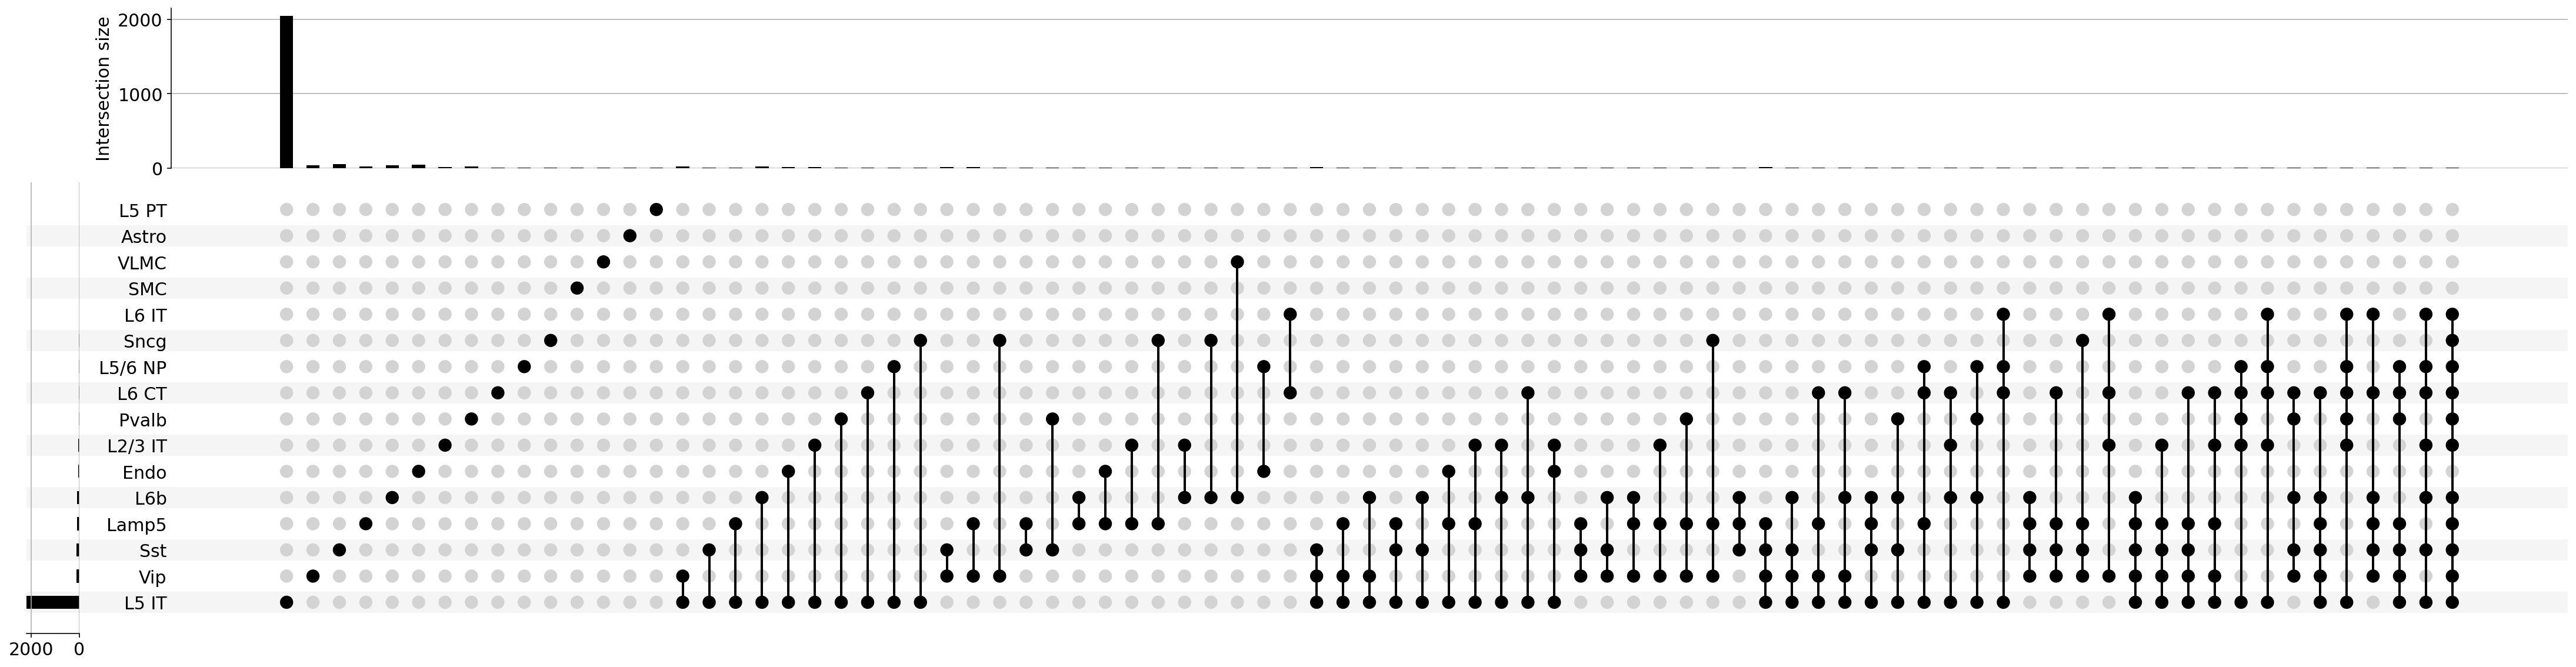

In [24]:
fig = plt.figure()
ax = upsetplot.plot(data, fig=fig)
#fig.savefig(trackfig("../../figures/smartseq_isoform_upset_sex.png", TRACKFIG, NB), bbox_inches='tight', dpi=300)
fig.show()

In [25]:
markers_isoform[markers_isoform.name.str.contains("Shank")]

,index,name,p_raw,p_corr,es,cluster,chromosome
99317,M,Shank1-203_ENSMUST00000107938,5.97886e-18,2.91529e-14,0.180516,L5 IT,7
99317,M,Shank1-203_ENSMUST00000107938,1.60548e-08,2.53665e-05,0.316532,Vip,7


In [26]:
markers_isoform

,index,name,p_raw,p_corr,es,cluster,chromosome
48065,F,4930512M02Rik-201_ENSMUST00000081896,2.98052e-06,0.00434857,3.02083,Astro,11
54590,F,Sdha-206_ENSMUST00000161434,3.27372e-06,0.00477636,5.33356,Astro,13
110822,M,Timm23-201_ENSMUST00000013845,1.00202e-07,3.54714e-05,5.60538,Astro,14
115490,M,Faim-201_ENSMUST00000035038,1.83143e-05,0.00648327,5.3108,Astro,9
203,F,Tram1-201_ENSMUST00000027068,1.15601e-07,0.00112017,3.24108,Endo,1
...,...,...,...,...,...,...,...
127282,M,Rpl37-201_ENSMUST00000045356,9.61722e-07,0.00151952,0.246257,Vip,15
127461,M,Basp1-201_ENSMUST00000058845,1.04551e-17,1.6519e-14,0.442518,Vip,15
132263,M,Son-203_ENSMUST00000117633,4.62264e-08,7.30377e-05,0.381471,Vip,16
132986,M,Srrm2-205_ENSMUST00000186961,3.57708e-06,0.00565178,0.447623,Vip,17


In [38]:
rm = nd(isoform.obs.eval("subclass_label == 'Vip'").values)
cm = nd(isoform.var.transcript_name.str.contains("Pvalb").values)

In [39]:
cm.shape

(69172,)

In [40]:
rm.shape

(6148,)

In [41]:
v = isoform.layers["log1p"][rm][:,cm].todense()

In [44]:
v.sum()

282.5696667074081

In [66]:
markers_isoform.query("cluster != 'L5 IT'").groupby("cluster")["name"].count()

cluster
Astro        4
Endo        56
L2/3 IT     46
L5 PT        3
L5/6 NP     13
L6 CT       30
L6 IT        8
L6b         87
Lamp5       91
Pvalb       33
SMC          6
Sncg        12
Sst        125
VLMC         5
Vip        132
Name: name, dtype: int64

In [72]:
markers_isoform.query("cluster != 'L5 IT' and chromosome != 'X' and chromosome != 'Y'")["name"].nunique()

418

In [73]:
markers_isoform.query("cluster != 'L5 IT' and chromosome != 'X' and chromosome != 'Y'").groupby("cluster")["name"].count().mean()

40.6